# Classification example 
with `MLflow`, `Catboost`, `Optuna` and `SHAP`.

## Imports

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from pathlib import Path

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score, recall_score
import sklearn
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from project_dirs import (
    PROJECT_DIR, DATA_DIR, MODELS_DIR, FIGURES_DIR
)
from utils import *

import optuna
from optuna.samplers import TPESampler
import joblib

import matplotlib as mpl
mpl.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 3

for i in [FIGURES_DIR, MODELS_DIR]:
    os.makedirs(i, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset, params

In [3]:
# load config
cnf = load_config(cnf_dir=PROJECT_DIR, cnf_name='config.yml')

In [4]:
# dataset
ds = sklearn.datasets.load_breast_cancer()
df = pd.DataFrame(ds['data'], columns=ds['feature_names'])
assert df.isna().sum().sum() == 0

df_preproc = preprocessing(
    df,
    cnf,
    drop_collinear_fs=True,
    datetime_cols=None,
    save_pickle=True,
    save_csv=True
    )

assert df.shape[0] == df_preproc.shape[0]

y = ds['target']
X = df_preproc.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=cnf['test_size'], random_state=cnf['random_state'],
    )
cat_features = np.where(X.dtypes == 'object')[0]

Trying to load a list of collinear features collinear_fs_vif_60.csv


## Optuna HO

### Objective function to optimize

In [4]:
def objective(trial):
    
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 15),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param, cat_features=cat_features)
    # model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=10)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = []
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_train_optuna, y_train_optuna = X_train.iloc[train_idx], y_train[train_idx]
        X_test_optuna, y_test_optuna = X_train.iloc[test_idx], y_train[test_idx]

        model.fit(
            X_train_optuna, y_train_optuna, 
            eval_set=[(X_test_optuna, y_test_optuna)], 
            verbose=0, 
            early_stopping_rounds=10
            )

        y_pred = model.predict(X_test_optuna)
        score = metrics.roc_auc_score(y_test_optuna, y_pred)
        cv_scores.append(score)
   
    return np.mean(cv_scores)

### Run Optuna study

In [5]:
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(
    objective, n_trials=cnf['optuna_n_trials'], timeout=cnf['optuna_timeout']
    ) # timeout in seconds

[I 2024-01-23 12:13:20,895] A new study created in memory with name: no-name-52f19924-38b4-4350-bb7f-24960554c2df
[I 2024-01-23 12:13:21,833] Trial 0 finished with value: 0.9493348300111073 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03367329909016507, 'l2_leaf_reg': 0.10670248262195946, 'colsample_bylevel': 0.07035118006272163, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 18, 'one_hot_max_size': 5, 'bagging_temperature': 1.0076976715509733}. Best is trial 0 with value: 0.9493348300111073.
[I 2024-01-23 12:13:22,033] Trial 1 finished with value: 0.8932103496657239 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.4473543881710518, 'l2_leaf_reg': 0.9902904924889474, 'colsample_bylevel': 0.010025515309873426, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 14, 'one_hot_max_size': 6, 'bagging_temperature': 6.508145094202877}. Best is trial 0 with value: 0.94933483

In [6]:
print(f"Number of completed trials: {len(study.trials)}")
print("Best trial:")
best_trial = study.best_trial

print(f"\tBest Score: {best_trial.value}")
print("\tBest Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

joblib.dump(study, os.path.join(MODELS_DIR, "optuna_study_cls.pkl"))
# study = joblib.load(os.path.join(MODELS_DIR, "optuna_study_cls.pkl"))

Number of completed trials: 200
Best trial:
	Best Score: 0.9690037006233742
	Best Params: 
    loss_function: Logloss
    learning_rate: 0.29566798847785053
    l2_leaf_reg: 0.9024854715685453
    colsample_bylevel: 0.03921899469217449
    depth: 15
    boosting_type: Plain
    bootstrap_type: Bernoulli
    min_data_in_leaf: 10
    one_hot_max_size: 19
    subsample: 0.9657568109747342


['C:\\CREDEM\\MLOps\\mlflow\\output\\models\\optuna_study_cls.pkl']

### Load study

In [12]:
study = joblib.load(os.path.join(MODELS_DIR, "optuna_study_cls.pkl"))
best_trial = study.best_trial

### HO visualizations

In [17]:
def optuna_visualization_plots(study, save=True, save_dir=FIGURES_DIR):
    """_summary_

    Args:
        study (_type_): _description_
        save (bool, optional): _description_. Defaults to True.
        save_dir (_type_, optional): _description_. Defaults to FIGURES_DIR.
    """
    fig = optuna.visualization.plot_param_importances(study)
    fig.savefig(os.path.join(save_dir, 'optuna_param_importances.png'))
    plt.show(fig)

    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.savefig(os.path.join(save_dir, 'optuna_optimization_history.png'))
    plt.show(fig1)

In [7]:
optuna_visualization_plots(study, save=True, save_dir=FIGURES_DIR)
# optuna.visualization.plot_param_importances(study)
# optuna.visualization.plot_optimization_history(study)

## Retrain model with selected parameters

In [6]:
# Train model with selected params. Save
params = study.best_params
model = CatBoostClassifier(**params, cat_features=cat_features)
model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=1, 
    early_stopping_rounds=cnf['early_stopping_rounds'])


metrics_scores = calculate_cls_metrics(model, X_test, y_test, metrics_list='auto', verbose=True)
# joblib.dump(model, os.path.join(MODELS_DIR, "opt_cls_120123.pkl"))

# model_name = "opt_cls_120123.pkl"
# model = joblib.load(os.path.join(MODELS_DIR, model_name))
# prefix = model_name

0:	learn: 0.6759848	test: 0.6770762	best: 0.6770762 (0)	total: 142ms	remaining: 2m 21s
1:	learn: 0.4515769	test: 0.4576060	best: 0.4576060 (1)	total: 144ms	remaining: 1m 11s
2:	learn: 0.3004744	test: 0.3094014	best: 0.3094014 (2)	total: 145ms	remaining: 48.2s
3:	learn: 0.2948858	test: 0.3007010	best: 0.3007010 (3)	total: 146ms	remaining: 36.5s
4:	learn: 0.2948274	test: 0.3006096	best: 0.3006096 (4)	total: 148ms	remaining: 29.4s
5:	learn: 0.2948001	test: 0.3005575	best: 0.3005575 (5)	total: 149ms	remaining: 24.6s
6:	learn: 0.2709886	test: 0.2797573	best: 0.2797573 (6)	total: 150ms	remaining: 21.3s
7:	learn: 0.2672539	test: 0.2791109	best: 0.2791109 (7)	total: 151ms	remaining: 18.7s
8:	learn: 0.2583785	test: 0.2675643	best: 0.2675643 (8)	total: 152ms	remaining: 16.7s
9:	learn: 0.2565089	test: 0.2679875	best: 0.2675643 (8)	total: 153ms	remaining: 15.2s
10:	learn: 0.2565091	test: 0.2679821	best: 0.2675643 (8)	total: 154ms	remaining: 13.8s
11:	learn: 0.2552770	test: 0.2696709	best: 0.267564

### Feature Importance

In [7]:
# prefix = str(datetime.today().date())
feature_importance_plot(model, figsize=(10,15), save=True, save_dir=FIGURES_DIR, prefix='')

In [ ]:
def feature_importance_plot(model, figsize=(10,15), save=True, save_dir=FIGURES_DIR, prefix=''):
    """Plot feature importance and safe the plot.

    Args:
        model (_type_): _description_
        save (bool, optional): _description_. Defaults to True.
        save_dir (_type_, optional): _description_. Defaults to FIGURES_DIR.
    """
    if prefix == '':
        prefix = str(datetime.today().date())

    f_importance_df = pd.DataFrame(
    [model.feature_names_, model.feature_importances_],
    ['features', 'f_importance']
    ).T.sort_values(by='f_importance', ascending=True)

    plt.figure(figsize=figsize)
    plt.barh(f_importance_df.features, f_importance_df.f_importance)
    plt.savefig(
        os.path.join(save_dir, f'feature_importance_{prefix}.png'), 
        bbox_inches='tight'
        )

### SHAP plot

In [ ]:
def calculate_shap(X, model, save=True, save_dir=FIGURES_DIR, prefix=''):
    """calculate_shap values, save plot

    Args:
        X (_type_): _description_
        model (_type_): _description_
        save (bool, optional): _description_. Defaults to True.
        save_dir (_type_, optional): _description_. Defaults to FIGURES_DIR.
        prefix (str, optional): _description_. Defaults to ''.
    """
    cat_features = np.where(X.dtypes=='object')[0]

    # SHAP VALUES FOR FEATURES 
    shap_values = model.get_feature_importance(Pool(X, label=y, 
                                                cat_features=cat_features), 
                                                type="ShapValues")
    shap_values = shap_values[:,:-1]
    assert shap_values.shape[0] == X.shape[0]
    if save:
        if prefix == '':
            prefix = str(dt.today().date())
        save_shap_plot(X, shap_values, fig_path=save_dir, prefix=prefix)


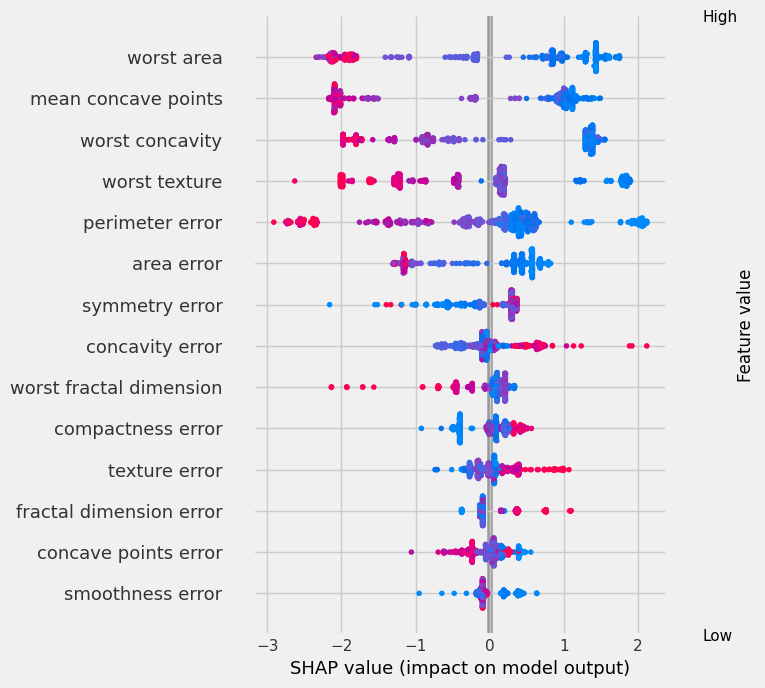

In [12]:
calculate_shap(X, y, model, save=True, save_dir=FIGURES_DIR, prefix='')

## Log with MLFlow
https://github.com/alfredodeza/mlflow-demo/blob/main/register/models.ipynb

In [ ]:
def get_mlflow_experiment(experiment_name, create=True, verbose=True):
    # experiment name: unique and case sensitive
    # Create an experiment if not existent
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        experiment_id = experiment.experiment_id
    else:
        if create:
            experiment_id = mlflow.create_experiment(
                experiment_name,
                artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
                tags={"version": "v1", "priority": "P1"},
            )
        else:
            print(f"Experiment {experiment_name} does not exist. To create it put create=True")
            return None
        
    if experiment:
        experiment = mlflow.get_experiment(experiment_id)
        if verbose:
            print(f"Name: {experiment.name}")
            print(f"Experiment_id: {experiment.experiment_id}")
            print(f"Artifact Location: {experiment.artifact_location}")
            print(f"Tags: {experiment.tags}")
            print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
            print(f"Creation timestamp: {experiment.creation_time}")
    return experiment


In [8]:
experiment = get_mlflow_experiment(experiment_name="Catboost cls breast cancer", create=True, verbose=True)

# mlflow.delete_experiment(experiment_id)

Name: Catboost cls breast cancer
Experiment_id: 421878044666324479
Artifact Location: file:///c:/CREDEM/MLOps/mlflow/src/mlruns
Tags: {'priority': 'P1', 'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1706029340259


In [14]:
todays_datetime = str(datetime.today())
mlflow.set_experiment(experiment.experiment_name)

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f'{todays_datetime}_catboost_cls'):
    run = mlflow.active_run()
    run_path = os.path.join(MLRUNS_DIR, run.info.experiment_id, run.info.run_id)
    
    # parameters
    for param, value in best_trial.params.items():
        mlflow.log_param(param, value)

    for param, value in cnf.items():
        mlflow.log_param(param, value)
    # mlflow.log_params(params)
    # mlflow.log_params('early_stopping_rounds', cnf['early_stopping_rounds'])
    # mlflow.log_param('features', X.columns)
    # mlflow.log_param('cat_features', cat_features)
    

    signature = infer_signature(X_test, model.predict(X_test))
    model_path = os.path.join(run_path, "model")
    mlflow.catboost.log_model(model, artifact_path=model_path, signature=signature)
    model_uri = mlflow.get_artifact_uri("model")

    # artifacts
    artifact_path = os.path.join(run_path, "artifacts")
    X_train.to_csv(os.path.join(OUTPUT_DIR, "X_train.csv"), index=False)
    pd.DataFrame(y_train).to_csv(os.path.join(OUTPUT_DIR, "y_train.csv"), index=False)
    X_test.to_csv(os.path.join(OUTPUT_DIR, "X_test.csv"), index=False)
    pd.DataFrame(y_test).to_csv(os.path.join(OUTPUT_DIR, "y_test.csv"), index=False)

    mlflow.log_artifact(os.path.join(OUTPUT_DIR, "X_train.csv"), artifact_path=os.path.join(artifact_path, "X_train"))
    mlflow.log_artifact(os.path.join(OUTPUT_DIR, "y_train.csv"), artifact_path=os.path.join(artifact_path, "y_train"))
    mlflow.log_artifact(os.path.join(OUTPUT_DIR, "X_test.csv"), artifact_path=os.path.join(artifact_path, "X_test"))
    mlflow.log_artifact(os.path.join(OUTPUT_DIR, "y_test.csv"), artifact_path=os.path.join(artifact_path, "y_test"))

    # mlflow.log_artifact('X_train', X_train)
    # mlflow.log_artifact('X_test', X_test)
    # mlflow.log_artifact('y_train', X_train)
    # mlflow.log_artifact('y_test', X_test)
    
    # metrics
    mlflow.log_metric("optuna_best_score", best_trial.value)
    for metric_name, metric_score in metrics_scores.items():
        mlflow.log_metric(metric_name, metric_score)

# Load model
# loaded_model = mlflow.catboost.load_model(model_uri)

# run_id = run.info.run_id
# mlflow.delete_run(run_id)  

## Predictions

In [68]:
# make prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

score_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
score_train = metrics.balanced_accuracy_score(y_train, y_pred_train)

print(f"Scores: train {score_train :.2f}, test {score_test :.2f}")


Scores: train 1.00, test 0.97


In [67]:
metrics.balanced_accuracy_score(y_train, y_pred_train)

NameError: name 'y_pred_train' is not defined